In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle
import os
import gc
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import json
from utilities import (
    RANDOM_STATE, TARGET_COL, N_FOLD, FOLD_STRAT_NAME,
)

INPUT_PATH = '../input/tabular-playground-series-oct-2021'
PATH_NOTEBOOK = '../input/preprocess'

PATH_PARAM = '../input/optuna-lightgbm'

In [2]:
train = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'train_unscaled.pkl')
)

In [3]:
with open(os.path.join(PATH_NOTEBOOK, 'feature_dic.pkl'), 'rb') as file:
    feature_dic = pickle.load(file)

In [4]:
#CONSTANT
FEATURE = feature_dic['feature']
CAT_COL = feature_dic['categorical']
NUMERIC_COL = feature_dic['numerical']

FOLD_LIST = range(train[FOLD_STRAT_NAME].nunique())

gc.collect()

93

# Set parameter

In [5]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'learning_rate': 0.01,
    'random_state': RANDOM_STATE,
    'verbose': -1,
    'n_jobs': -1,
}

#import lgb optimized parameter (file_name is wrong :()

with open(os.path.join(PATH_PARAM, 'final_xgb_param.pkl'), 'rb') as file:
    param_lgb_final = pickle.load(file)
    
params.update(param_lgb_final)

#pretty print
print(json.dumps(params, indent=4))

{
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "auc",
    "learning_rate": 0.01,
    "random_state": 383920,
    "verbose": -1,
    "n_jobs": -1,
    "num_leaves": 108,
    "bagging_fraction": 0.9826419035313325,
    "bagging_freq": 3,
    "feature_fraction": 0.4391703923164765,
    "lambda_l1": 9.981933259825583,
    "lambda_l2": 4.787223416853744,
    "min_data_in_leaf": 47,
    "extra_trees": true,
    "min_gain_to_split": 1.3870747701430455,
    "path_smooth": 1.6530551435631298
}


# TRAIN

In [6]:
score = 0
model_list = []

prediction_df = pd.DataFrame(
    {
        'fold': train[FOLD_STRAT_NAME],
        'prediction': np.zeros((train.shape[0]))
    }
)


for i, fold_ in enumerate(FOLD_LIST):

    mask_train = (train[FOLD_STRAT_NAME] != fold_)
    mask_test = (train[FOLD_STRAT_NAME] == fold_)
    
    
    train_x, train_y = train.loc[mask_train, FEATURE], train.loc[mask_train, TARGET_COL]
    test_x, test_y = train.loc[mask_test, FEATURE], train.loc[mask_test, TARGET_COL]

    model = lgb.train(
        params,
        lgb.Dataset(train_x, label=train_y,categorical_feature=CAT_COL), 100000,
        valid_sets = lgb.Dataset(test_x, label=test_y,categorical_feature=CAT_COL),
        valid_names ='validation', verbose_eval=100, early_stopping_rounds = 100,
    )
    
    #oof prediction
    prediction_df.loc[mask_test, 'prediction'] = model.predict(test_x)
    
    #evaluate score and save model for importance/prediction
    score_fold = model.best_score['validation']['auc'] 
    score += score_fold/N_FOLD
    
    model_list.append(model)
    
    print('\nFold: {}; Auc: {:.5f}\n'.format(fold_, score_fold))
    print('-'*50)
    print('\n\n\n')
    gc.collect()
    
print('CV-Auc: {:.5f}\n'.format(score))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	validation's auc: 0.832096
[200]	validation's auc: 0.836135
[300]	validation's auc: 0.839324
[400]	validation's auc: 0.841487
[500]	validation's auc: 0.843086
[600]	validation's auc: 0.844609
[700]	validation's auc: 0.845907
[800]	validation's auc: 0.847052
[900]	validation's auc: 0.848049
[1000]	validation's auc: 0.848914
[1100]	validation's auc: 0.849648
[1200]	validation's auc: 0.850321
[1300]	validation's auc: 0.850938
[1400]	validation's auc: 0.85146
[1500]	validation's auc: 0.851921
[1600]	validation's auc: 0.852312
[1700]	validation's auc: 0.852661
[1800]	validation's auc: 0.852965
[1900]	validation's auc: 0.853251
[2000]	validation's auc: 0.853505
[2100]	validation's auc: 0.853735
[2200]	validation's auc: 0.85394
[2300]	validation's auc: 0.854133
[2400]	validation's auc: 0.854302
[2500]	validation's auc: 0.854457
[2600]	validation's auc: 0.8546
[2700]	validation's auc: 0.854734
[2800]	validation's auc: 0.854859

# Feature importance

In [7]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = FEATURE


for fold_, model in enumerate(model_list):
    feature_importances['fold_{}'.format(fold_ + 1)] = model.feature_importance(importance_type='gain')

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

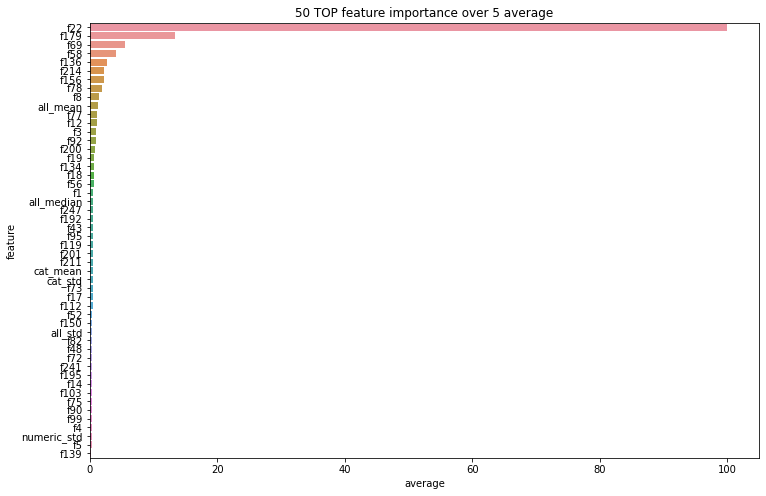

In [8]:
scaler = MinMaxScaler(feature_range=(0, 100))

average_importance = feature_importances.drop('feature', axis = 1).mean(axis=1)

feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(average_importance))
feature_importances = feature_importances.sort_values(by='average', ascending=False)

feature_importances[['feature', 'average']].to_csv('feature_importances.csv',index=False)

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.head(50), x='average', y='feature');
plt.title(f'50 TOP feature importance over {N_FOLD} average')

# TEST Blending

In [9]:
del train
gc.collect()

36

In [10]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [11]:
pred_test = np.zeros(test.shape[0])

for fold_, model in enumerate(model_list):
    pred_test += model.predict(test)/N_FOLD


# SAVE RESULT

In [12]:
submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
submission['target'] = pred_test

submission.to_csv('submission.csv', index = False)

In [13]:
prediction_df.to_csv('oof_prediction', index = False)